# DTSC301 Assignment 2: The Dermatologist's Digital Loupe 🔍
## A Deep Learning Approach to Skin Lesion Classification

**Author:** Ana Luiza Lerch Paiva

**Date:** July 18, 2025

---

### Introduction
**Project Overview:** This project is for a major hospital's dermatology department. The goal is to build a deep learning model that can assist dermatologists by classifying skin lesion images as either benign (negative class) or malignant (positive class). The model is designed to help diagnostic support tool.

**Objective:** To design, build, and evaluate a Convolutional Neural Network (CNN) that achieves high reliability in classifying lesion images.

**Dataset:** We will be using the ISIC dataset, which contains:
  * Dermoscopic images of skin lesions.
  * A metadata file ('ISIC_Metadata.csv') containing the image filenames and their corresponding diagnostic labels.

**Method:** The core of our solution will be a CNN, as this architecture is purpose-built for image recognition tasks.

**Clinical Priority**: Maximize sensitivity (recall) to minimize the risk of missed cancer diagnoses.

### 1. Set Up and Environment Configuration

This section handles all the initial setup required for the project. It includes:

- Environment setup and connecting to file storage and setting up the hardware (GPU) to accelerate the model training process

- Importing all necessary libraries for data handling, visualization, and model building

- Reproducibility: The set_seed() function ensures identical results across multiple runs by controlling all random processes.

- Defining centralized file paths

- Importing data

In [1]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check GPU availability

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU available: {physical_devices}")

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


* CNNs are computationally very demanding. Using GPU can dramatically speed up this process, reducing training time from potentially hours to minutes.
* If GPU wasn't detected, the program will run on the standard, slower CPU instead.

In [3]:
# IMPORT LIBRARIES

import os
import shutil
import random
import cv2
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score)
from PIL import Image
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout,
    GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight


In [4]:
# REPRODUCIBILITY AND AESTHETIC CONFIGURATION
# Set seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_seed()

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
blues_palette = ['#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6','#9ecae1', '#c6dbef', '#deebf7']
blues = plt.cm.Blues(np.linspace(0.2, 1, 8))

In [5]:
# FILE PATHS AND LOAD DATA
# Define paths
core_path = "/content/drive/MyDrive/DeepLearning_Projects/DTSC301_A2"
data_path = os.path.join(core_path, "data") # where all datasets are
image_dir = os.path.join(data_path, "ISIC_data") #where all images unzipped are
metadata_file = os.path.join(data_path, "ISIC_metadata.csv")
organized_data = os.path.join(data_path, "organized_data/")
models_path = os.path.join(core_path, "models") # models are being saved
plots_path = os.path.join(core_path, "output") # images from plots

# Load metadata
df = pd.read_csv(metadata_file)
print(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")

Dataset loaded: 7818 samples, 13 features


### 2. Data Integrity and Exploratory Analysis (EDA)

Before we dive into exploring the data's patterns, it's fundamental to ensure the data is complete and functional before we even think about training the model. We will perform two critical checks: we'll check each column in our metadata file for null or missing values. This helps us understand the completeness of our dataset.

The goal of EDA is to understand the landscape of our data before we build on it. The single most important discovery from our initial analysis is the **severe class imbalance**: for every one malignant case, we have approximately six benign cases.

This isn't just a statistic, by ignoring it would lead to a useless model that simply predicts 'benign'. Because of the objective of this project, **we will not use random splitting strategy**. Otherwhise, we could accidentally create validation or test sets with very few (or zero) malignant cases.

To overcome this issue, we use **stratified splitting**. Stratification ensures that the 6:1 benign-to-malignant ratio is perfectly preserved across our training, validation, and test sets. This guarantees a few things:

1. **Meaningful Training**: The model is guaranteed to see a representative proportion of malignant cases in every training epoch.

2. **Reliable Evaluation**: Our validation and test metrics are trustworthy because they are calculated on a dataset that mirrors the real-world distribution of our data.

3. **Defensible Results**: We can confidently defend our model's performance because we've built and tested it on properly structured, representative data subsets.


In [6]:
# 2.a. METADATA INTEGRITY CHECK
print("Checking for missing values in metadata")
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    print("Found missing values in the following columns:")
    print("=" * 60)

    # Create summary table
    missing_summary = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Count': missing_values.values,
        'Percentage': (missing_values.values / len(df) * 100).round(2)
    }).sort_values('Missing Count', ascending=False)

    print(missing_summary.to_string(index=False))
    print("=" * 60)

    print(f"Total rows in dataset: {len(df)}")
    print(f"Columns with missing data: {len(missing_values)}")
    print("=" * 60)


Checking for missing values in metadata
Found missing values in the following columns:
             Column  Missing Count  Percentage
anatom_site_general           1539       19.69
         age_approx             75        0.96
                sex             37        0.47
Total rows in dataset: 7818
Columns with missing data: 3


In [7]:
# 2.b. Check for missing values in classification column
missing_class = df['classification'].isnull().sum()
print(f"Missing values in 'classification': {missing_class}")

Missing values in 'classification': 0


**RESULTS:**

Our checks confirm that all 7,818 labeled images have corresponding files in our directory.

The check reveals missing values in metadata columns: '*age_approximate*', '*anatom_site_general*' and '*sex*'. For our current project, which focuses exclusively on building a CNN using the images and their direct classification, this is not an immediate blocker as we are not using these specific features.

However, documenting this is crucial. If we were to enhance our model later to be multi-modal (using both images and patient data), we would need to address these missing values, likely through imputation.



Dataset Overview:
Total samples: 7818
Shape: (7818, 13)

Class Distribution:
Benign: 6705 (85.8%)
Malignant: 1113 (14.2%)
Imbalance ratio: 6.0:1


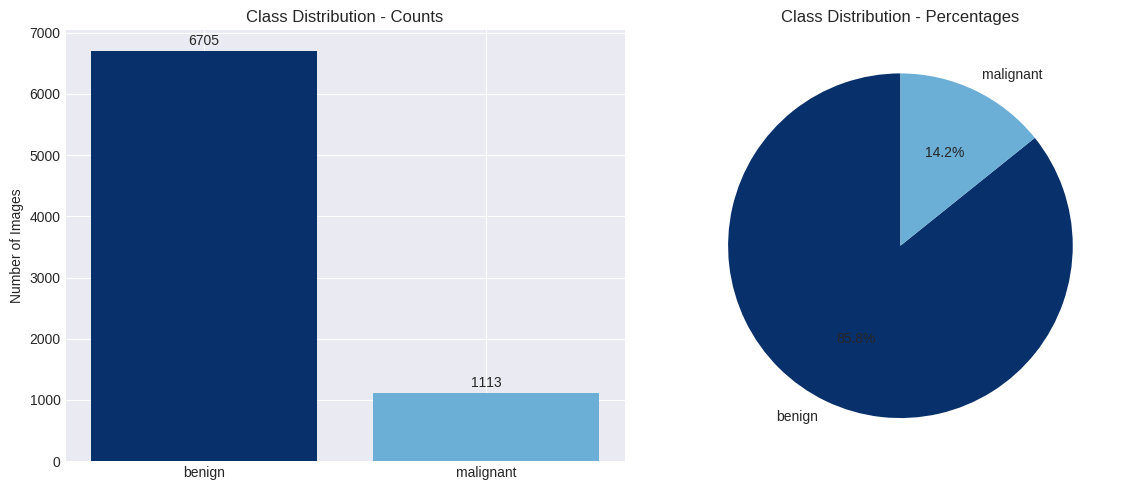

In [8]:
# 2. EXPLORATORY DATA ANALYSIS - EDA
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Shape: {df.shape}")

class_counts = df['classification'].value_counts()
total_samples = len(df)
benign_count = class_counts['benign']
malignant_count = class_counts['malignant']
imbalance_ratio = benign_count / malignant_count

print(f"\nClass Distribution:")
print(f"Benign: {benign_count} ({benign_count/total_samples*100:.1f}%)")
print(f"Malignant: {malignant_count} ({malignant_count/total_samples*100:.1f}%)")
print(f"Imbalance ratio: {imbalance_ratio:.1f}:1")

plt.figure(figsize=(12, 5))

colors = [blues_palette[0], blues_palette[4]]
plt.subplot(1, 2, 1)
bars = plt.bar(class_counts.index, class_counts.values, color=colors)
plt.title('Class Distribution - Counts')
plt.ylabel('Number of Images')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
            f'{int(height)}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Class Distribution - Percentages')
plt.tight_layout()
plt.show()

Check Image Dimension
Width range: 600 - 600 pixels
Height range: 450 - 450 pixels
Most common dimensions: (600, 450)


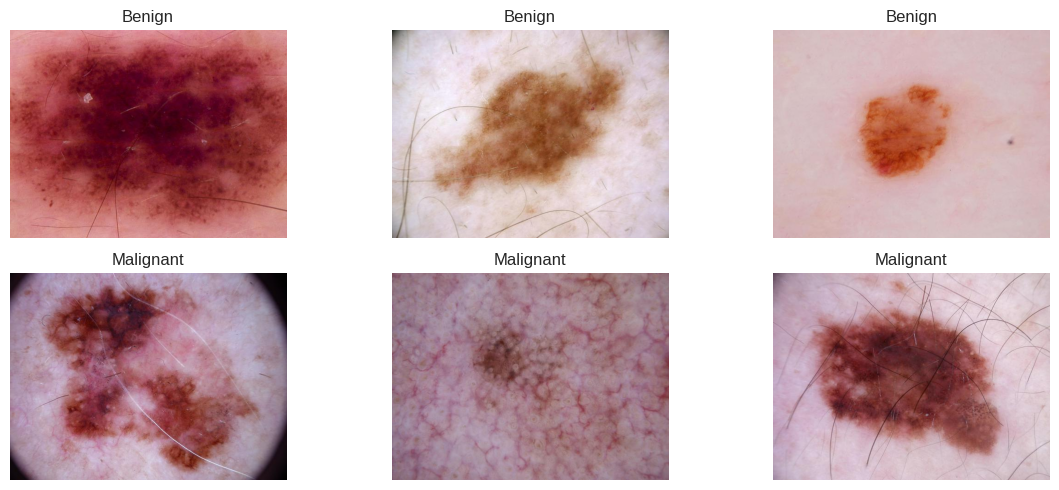

In [9]:
# 2.1. IMAGE DIMENSION CHECK
print("Check Image Dimension")

# check image dimensions sample
sample_files = df.sample(min(100, len(df)), random_state=42)
dimensions = []

for _, row in sample_files.iterrows():
    img_path = os.path.join(image_dir, f"{row['file_id']}.jpg")
    try:
        img = cv2.imread(img_path)
        if img is not None:
            h, w, c = img.shape
            dimensions.append((w, h))
    except Exception as e:
      print(f"Error reading image {img_path}:{e}")

if dimensions:
    widths, heights = zip(*dimensions)
    print(f"Width range: {min(widths)} - {max(widths)} pixels")
    print(f"Height range: {min(heights)} - {max(heights)} pixels")
    print(f"Most common dimensions: {max(set(dimensions), key=dimensions.count)}")

# display sample images
plt.figure(figsize=(12, 5))
for i, cls in enumerate(['benign', 'malignant']):
    samples = df[df['classification'] == cls].sample(min(3, len(df[df['classification'] == cls])))
    for j, (_, row) in enumerate(samples.iterrows()):
        plt.subplot(2, 3, i*3 + j + 1)
        img_path = os.path.join(image_dir, f"{row['file_id']}.jpg")
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"{cls.title()}")
            plt.axis('off')
plt.tight_layout()
plt.show()

**Image Resizing and Resolution**

The dataset consists of images with an original resolution of 450x600 pixels. However, the selected pre-trained convolutional neural networks (CNNs), specifically VGG16 and ResNet50, require a specific input shape of 224x224 pixels.  The reason for this is that their internal structure was designed and trained using the ImageNet database, which contains images of that specific dimension.

Therefore, our first preprocessing step is to resize all images to 224x224. This transformation results in a significant reduction of pixel data, approximately 81.4%. However, I am proceeding based on the common understanding that the key visual information for identifying skin cancer—such as lesion patterns, textures, and colours—is still present and detectable by the models at this smaller resolution.

For the purpose of robust and valid model comparison, all models in this study will be assessed using the same 224x224 input size. While a model like InceptionV3 might achieve better results with its preferred 299x299 input, using different sizes for different models would not be a controlled experiment. By standardizing the input size, allows for a direct and equitable comparison of their feature extraction (apples to apples) capabilities on the ISIC dataset.

## 3. Data Preparation and Augmentation

Now we'll perform our data split to address the severe class imbalanced, the next step then is to create an efficient pipeline to feed images to our CNN. This approach streamline image loading, and is where the *ImageDataGenerator* becomes essential.

1. **Directory Structure**: First, we physically copy the images into a specific folder structure: *train/benign*, *train/malignant*, etc. We do this because Keras's *flow_from_directory* function is designed to work with this layout. It automatically infers the class labels from the folder names, which is efficient and less prone to error than managing labels manually.


2. **Data Augmentation for Training ONLY**: Our training set has a limited number of malignant examples. To prevent the model overfitting, we use data augmentation. For each training batch, the *ImageDataGenerator* creates slightly modified versions of the images—rotating, shifting, zooming, and flipping them. This creates a stream of unique images, teaching the model to recognize the core features of a lesion, regardless of its orientation or position. We **do not** augment the validation or test data. We need to evaluate the model on clean, original images to get an honest assessment of its performance.


3. **Class Weights**: Our main strategy to fight the class imbalance problem is to use class weights during the model training. This method tells the model to pay much more attention to the malignant class, which is the minority and more important to detect.

I have set up two experiments to test this strategy properly:

* **First Experiment (Original Weights)**: Here, I calculated the weights based on the number of samples in each class. This resulted in weights of {benign: 0.583, malignant: 3.512}. With these numbers, if the model makes a mistake on a malignant image, the **penalty is about 6 times higher** than for a mistake on a benign image. My plan is to use these weights for all my first models to create a fair baseline for comparison.

* **Second Experiment (Balanced Weights)**: For comparison, I will also train all the models with equal weights: {benign: 1.0, malignant: 1.0}. By comparing the results from the first experiment to this one, I can see and measure how much the **class weights** strategy helps to **improve the model's performance**.


In [10]:
# # 3.1. DATA STRATIFICATION & FILE ORGANIZATION
print("\nSplitting data: 70% train, 15% validation, 15% test")

# Create directories for the organized data
train_path = os.path.join(organized_data, 'train')
val_path = os.path.join(organized_data, 'validation')
test_path = os.path.join(organized_data, 'test')

# First split: train vs. (val+test)
train_df, temp_df = train_test_split( df,
    test_size=0.3,  # 30% for val+test
    stratify=df['classification'],
    random_state=42)

# Second split: val vs. test
val_df, test_df = train_test_split(temp_df,
    test_size=0.5,  # Split the 30% into two equal parts (15% each)
    stratify=temp_df['classification'],
    random_state=42)

print(f"Training: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Verify stratification is preserved
for name, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    subset_counts = subset['classification'].value_counts()
    b_count = subset_counts.get('benign', 0)
    m_count = subset_counts.get('malignant', 0)
    ratio = b_count / m_count if m_count > 0 else 0
    print(f"{name}: {b_count} benign, {m_count} malignant (ratio: {ratio:.1f}:1)")


Splitting data: 70% train, 15% validation, 15% test
Training: 5472 samples
Validation: 1173 samples
Test: 1173 samples
Train: 4693 benign, 779 malignant (ratio: 6.0:1)
Validation: 1006 benign, 167 malignant (ratio: 6.0:1)
Test: 1006 benign, 167 malignant (ratio: 6.0:1)


**Statistical Validation:** With 167 malignant cases in both validation and test sets, we have sufficient sample sizes for metric calculations. This ensures our recall measurements will be statistically meaningful rather than subject to random fluctuation that could occur with smaller malignant sample sizes.

In [11]:
# 3.2. DATA PREPROCESSING & PIPELINE SETUP

# Applies data augmentation (rotations, shifts, flips, zoom) + normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest')

# For validation and test data, we only rescale the pixels
# Only normalization, NO augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

val_generator = valid_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

print(f"Class indices: {train_generator.class_indices}")

# Get class distribution from the generator
counter = Counter(train_generator.classes)
total = sum(counter.values())
n_classes = len(counter)

# ---- CLASS WEIGHT EXPERIMENT SETUP ------
# Get class distribution from the generator
counter = Counter(train_generator.classes)
print(f"Class distribution: {counter}")

# Define different class weight strategies
weight_strategies = {
    'Original': {0: 0.583, 1: 3.512},  # Original weights from distribution calculation
    'Balanced': {0: 1.0, 1: 1.0}       # Equal weighting (no bias)
}
print(f"Weight strategies to test: {list(weight_strategies.keys())}")

# Initialize results storage
experiment_results = {}
experiment_histories = {}

# build with Gemini

Found 4228 images belonging to 2 classes.
Found 1173 images belonging to 2 classes.
Found 1173 images belonging to 2 classes.
Class indices: {'benign': 0, 'malignant': 1}
Class distribution: Counter({np.int32(0): 3637, np.int32(1): 591})
Weight strategies to test: ['Original', 'Balanced']


**Techinical strategy used for preprocessing the pipeline for CNN training with imbalanced medical imaging data.**

- **Batch Size Considerations**: The 32-image batch size balances computational efficiency with gradient stability. With our class imbalance, each batch typically contains ~27 benign and ~5 malignant cases, ensuring the model sees malignant examples regularly during training while maintaining manageable memory usage.

- **Data Augmentation**: With only 1,113 malignant cases, we need artificial data variation to prevent overfitting. Training data gets rotated, flipped, zoomed versions.

- **No Augmentation for Val/Test**: We need clean, unmodified images for honest evaluation of model performance.

- **Class Weights**: Forces the CNN to pay equal attention to malignant cases despite them being 6x fewer. Without this, the model would just predict "benign" for everything. Better be safe in cancer detectiont than be sorry.

- **224x224 Size**: Standard input size for pretrained models like VGG16, ResNet50, InceptionV3 and ModileNetV2.



*Note: I tried to build a function several times, it would make the code less wordy and repetitive, but I ended up having so many issues, and I restarted so many times, so last time I rebuilt the model again was less than 24 hours to the deadline, and I ended up gaving up. Decide keeping it simple, repetitive, but at least working and I could explain what it did.*


### 5. Modeling Strategy
 The primary goal was to create a reusable, consistent, and readable workflow for building, evaluating, and saving multiple models, which I failed. So, this modular approach will have code repetition but ensure all models are compared under the same conditions.

* Model Creation Functions: created to generate the model architectures for this study.

* Valuation and Utility Functions: to standardize the assessment and management of models.

By applying this methodology, we improve the scientific comparisson.

In [12]:
# 5.1. HELPER FUNCTIONS FOR MODEL DEVELOPMENT

def create_baseline_naive_model(input_shape=(224, 224, 3)):
    """
    Create a naive baseline model that just flattens the input
    and uses a single dense layer for classification.
    """
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Recall', 'Precision']
    )

    return model

def create_baseline_cnn(input_shape=(224, 224, 3)):
    """
    Create a simple baseline CNN with a few convolution layers.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Recall', 'Precision']
    )

    return model

def create_transfer_model(model_name, input_shape=(224, 224, 3)):
    """
    Creates a transfer learning model using specified base architecture.
    """
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Freeze the base model layers
    base_model.trainable = False

    # Create the model with the base and custom top layers
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model with metrics focused on our clinical priority (recall)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Recall', 'Precision']
    )

    return model

# Code generated by Claude.ai

**Model Evaluation and Results Management**
This section contains the utility functions that standardize how we assess and save our trained models. These functions ensure consistent evaluation across all architectures and provide performance metrics focused on our clinical priorities.


In [13]:
# 5.2. Model Evaluation and Results Management

def evaluate_model(model, test_generator):
    """
    called when we finish model training to get its final performance metrics on the test set
    """
    # Reset the test generator
    test_generator.reset()

    # Get predictions
    y_pred_probs = model.predict(test_generator, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int)
    y_true = test_generator.classes  # get labels

    # Calculate metrics
    test_loss, test_accuracy, test_recall, test_precision = model.evaluate(
        test_generator, verbose=0)
    f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-10)
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Return metrics
    return {
        'accuracy': test_accuracy,
        'recall': test_recall,
        'precision': test_precision,
        'f1_score': f1_score,
        'auc': roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr}

def save_model_with_results(model, history, model_name, test_generator, save_dir):
    """
    Save a trained model and evaluate its performance.
    """
    model_path = os.path.join(save_dir, f"{model_name}.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")

    # Evaluate the model
    results = evaluate_model(model, test_generator)

    # Print metrics
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Recall (Sensitivity): {results['recall']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    print(f"AUC: {results['auc']:.4f}")

    return results

# code generated by Claude.ai

#### 6. Model Training
Before we begin the main process of training our models, we'll review the setup for this first round of experiments with original weights.

First, we're defining our core strategy. For this entire run, every model we test—from the simple baseline to the complex transfer learning models—will use the 'Original' class weights. This is our primary method for addressing the class imbalance, and by applying it consistently, we ensure a fair comparison across all model architectures.

Therefore, we need a place to systematically log the outcome of each test. To do that, we've set up two empty containers:

- all_results will be our summary sheet, where we'll record the final performance scores for each model.

- all_histories will store the learning progress, which we'll use to plot our learning curves later.

So, with our primary strategy defined and our result logs prepared, we will proceed with sequentially model training .

In [14]:
# -----------------------------------------------------------------------------
# 6.1. SETUP ORIGINAL WEIGHTS STRATEGY
# -----------------------------------------------------------------------------
# Define class weight strategies (we'll use original weights for now)
weight_strategies = {
    'Original': {0: 0.583, 1: 3.512}  # Original weights based on class distribution
}

# Initialize storage for results
all_results = {}
all_histories = {}

print("Original weight setup complete.")

Original weight setup complete.


In [15]:
# 6.2. EXPERIMENT 1: BASELINE NAIVE MODEL

print("\n" + "="*60)
print("           BASELINE NAIVE MODEL")
print("="*60)
# Clear session for clean experiment
tf.keras.backend.clear_session()

# Create naive baseline model
naive_model = create_baseline_naive_model()

# Train naive model for 10 epochs with original weights
naive_history = naive_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Original'],
    verbose=1)

# Evaluate and save naive model results
naive_results = save_model_with_results(
    naive_model,
    naive_history,
    "baseline_naive",
    test_generator,
    models_path)

# Store results for comparison
all_results["Naive_Original"] = naive_results
all_histories["Naive_Original"] = naive_history
# Code from week 5 and assignment 1


           BASELINE NAIVE MODEL


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - Precision: 0.1397 - Recall: 0.7269 - accuracy: 0.3200 - loss: 10.9539 - val_Precision: 0.1424 - val_Recall: 1.0000 - val_accuracy: 0.1424 - val_loss: 0.6941
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 442ms/step - Precision: 0.1461 - Recall: 0.9308 - accuracy: 0.1964 - loss: 0.7006 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.8576 - val_loss: 0.6915
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 447ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.8563 - loss: 0.6959 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.8576 - val_loss: 0.6898
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 443ms/step - Precision: 0.0587 - Recall: 0.0080 - accuracy: 0.8529 - loss: 0.6977 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.8576 - val_loss: 0.6884
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 442ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.863

**RESULTS:** We can observe that the naive model has completely failed, achieving **86% accuracy but 0% recall** and **0% precision. The F1 Score of 0.00 and AUC of 0.50** (equivalent to random chance) indicate the model learned to predict "benign" for every single case, making it clinically useless.

The training logs reveal the model's dysfunction - after the first epoch showed some learning (73% recall), the model collapsed and learned to always predict the majority class. This demonstrates why **class weights alone** are insufficient for handling severe imbalance in medical imaging without proper architecture design.

**Clinical Interpretation**: The AUC of 0.50 (random chance) proves the model has learned no meaningful patterns from the dermoscopic images. The high accuracy is misleading - it simply reflects the dataset's natural imbalance, not actual diagnostic capability.

**In cancer screening, high accuracy with zero sensitivity is catastrophic. This baseline failure reinforces why we prioritize recall over accuracy in our subsequent models.**

Next: The baseline CNN should demonstrate that proper convolutional architecture can extract meaningful visual patterns where the naive approach failed completely.

In [16]:
# 6.3. EXPERIMENT 2: NAIVE CNN (ONE-TIME EXPERIMENT)

print("\n" + "="*60)
print("           BASELINE CNN MODEL")
print("="*60)

# Clear session for clean experiment
tf.keras.backend.clear_session()

# Create baseline CNN model
baseline_model = create_baseline_cnn()
# Create checkpoint to save best model
baseline_checkpoint = ModelCheckpoint(
    os.path.join(models_path, 'baseline_cnn_original_best.keras'),
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1)

# Train with original weight strategy
baseline_history = baseline_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Original'],
    callbacks=[baseline_checkpoint],
    verbose=1)

# Evaluate and save results
baseline_results = save_model_with_results(
    baseline_model,
    baseline_history,
    "baseline_cnn_original",
    test_generator,
    models_path)

# Store results for comparison
all_results["BaseCNN_Original"] = baseline_results
all_histories["BaseCNN_Original"] = baseline_history



           BASELINE CNN MODEL


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 73s 524ms/step - Precision: 0.1551 - Recall: 0.4515 - accuracy: 0.5798 - loss: 1.0031 - val_Precision: 0.3750 - val_Recall: 0.0539 - val_accuracy: 0.8525 - val_loss: 0.6861
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 68s 515ms/step - Precision: 0.1514 - Recall: 0.1587 - accuracy: 0.7636 - loss: 0.6769 - val_Precision: 0.4000 - val_Recall: 0.0958 - val_accuracy: 0.8508 - val_loss: 0.6864
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 69s 517ms/step - Precision: 0.1969 - Recall: 0.3219 - accuracy: 0.7126 - loss: 0.6858 - val_Precision: 0.3396 - val_Recall: 0.1078 - val_accuracy: 0.8431 - val_loss: 0.6906
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 69s 519ms/step - Precision: 0.1911 - Recall: 0.5208 - accuracy: 0.5920 - loss: 0.7004 - val_Precision: 0.3143 - val_Recall: 0.1976 - val_accuracy: 0.8244 - val_loss: 0.6967
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 69s 517ms/step - Precision: 0.3692 - Recall: 0.4243 - accuracy: 0.8047 - loss: 0.6823 - val_Precision: 0.2600 - val_Recall: 0.3114 - val_accuracy: 0.7758 - val_loss: 0.6937
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 69s 520ms/step - Precision: 0.3019 - Recall: 0.3331 - accuracy: 0.7817 - loss: 0.6941 - val_Precision: 0.2857 - val_Rec

**RESULTS:** The **baseline CNN shows substantial improvement over the failed naive model**, achieving 59% accuracy and 91% recall while reaching 24% precision. The F1 score of 0.39 indicates reasonable balance between precision and recall.

This model represents a clinically promising scenario - **catching 91 out of 100 cancer cases** while maintaining some precision control. However, 76% of positive predictions would be false alarms, creating a high burden of unnecessary biopsies that limits clinical viability.

The dramatic improvement from naive (AUC: 0.50, 0% recall) to CNN (AUC: 0.79, 91% recall) powerfully demonstrates that convolutional layers can extract diagnostic features from images. It seeems the model has learned to recognize visual patterns associated with malignancy rather than simply predicting based on class distribution.

Unlike the naive model's collapse, the **CNN showed consistent learning throughout training**, with the final epochs achieving the target high recall (93-94% validation recall), demonstrating stable convergence toward our clinical objectives.

This baseline establishes that basic convolutional architecture can achieve clinically relevant sensitivity. The question now is whether pre-trained ImageNet features can maintain this >90% recall while reducing false alarms for practical deployment.

**Next: Testing VGG16, ResNet50, InceptionV3 and MobileNetV2 to leverage sophisticated feature extraction learned from millions of images.**


           BASELINE MODELS COMPARISON (NAIVE VS CNN)


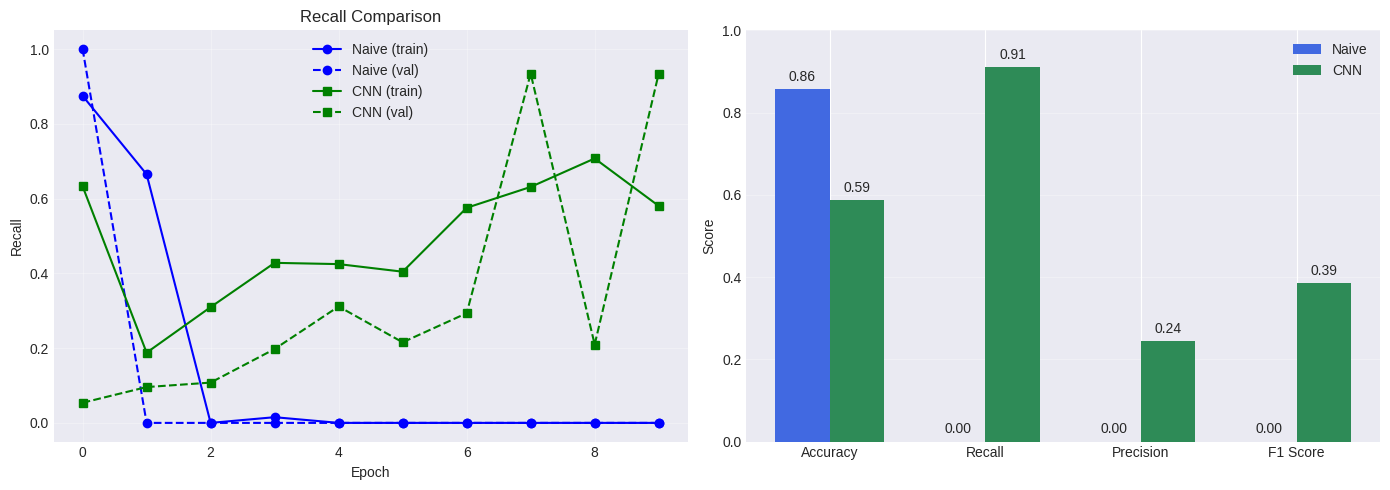

Recall improvement: 0.9102


In [17]:
# 6.4. Baseline Models Comparison (Naive vs CNN)
print("\n" + "="*60)
print("           BASELINE MODELS COMPARISON (NAIVE VS CNN)")
print("="*60)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training and validation recall
ax1.plot(naive_history.history['Recall'], 'b-o', label='Naive (train)')
ax1.plot(naive_history.history['val_Recall'], 'b--o', label='Naive (val)')
ax1.plot(baseline_history.history['Recall'], 'g-s', label='CNN (train)')
ax1.plot(baseline_history.history['val_Recall'], 'g--s', label='CNN (val)')
ax1.set_title('Recall Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Recall')
ax1.legend()
ax1.grid(alpha=0.3)

# Model metrics comparison
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
naive_scores = [naive_results['accuracy'], naive_results['recall'],
                naive_results['precision'], naive_results['f1_score']]
cnn_scores = [baseline_results['accuracy'], baseline_results['recall'],
              baseline_results['precision'], baseline_results['f1_score']]

x = np.arange(len(metrics))
width = 0.35
ax2.bar(x - width/2, naive_scores, width, label='Naive', color='royalblue')
ax2.bar(x + width/2, cnn_scores, width, label='CNN', color='seagreen')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.set_ylabel('Score')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(naive_scores):
    ax2.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center')
for i, v in enumerate(cnn_scores):
    ax2.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

print(f"Recall improvement: {baseline_results['recall'] - naive_results['recall']:.4f}")
# code generated by Claude.ai

In [18]:
# 6.5. EXPERIMENT 3: VGG16 Transfer Learning Model
print("\n" + "="*60)
print("           VGG16 MODEL WITH ORIGINAL WEIGHTS")
print("="*60)

# Clear session for clean experiment
tf.keras.backend.clear_session()

# Create VGG16 model
vgg_model = create_transfer_model('VGG16')
# Create checkpoint to save best model
vgg_checkpoint = ModelCheckpoint(
    os.path.join(models_path, 'vgg16_original_best.keras'),
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1)

# Train with original weight strategy
vgg_history = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Original'],
    callbacks=[vgg_checkpoint],
    verbose=1)

# Evaluate and save results
vgg_results = save_model_with_results(
    vgg_model,
    vgg_history,
    "vgg16_original",
    test_generator,
    models_path)

# Store results for comparison
all_results["VGG16_Original"] = vgg_results
all_histories["VGG16_Original"] = vgg_history



           VGG16 MODEL WITH ORIGINAL WEIGHTS
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 84s 613ms/step - Precision: 0.3075 - Recall: 0.7275 - accuracy: 0.7273 - loss: 0.5822 - val_Precision: 0.6712 - val_Recall: 0.2934 - val_accuracy: 0.8789 - val_loss: 0.3505
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 616ms/step - Precision: 0.3592 - Recall: 0.8341 - accuracy: 0.7759 - loss: 0.4417 - val_Precision: 0.3348 - val_Recall: 0.8982 - val_accuracy: 0.7315 - val_loss: 0.5103
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 622ms/step - Precision: 0.3466 - Recall: 0.8432 - accuracy: 0.7601 - loss: 0.4568 - val_Precision: 0.3912 - val_Recall: 0.7964 - val_accuracy: 0.7945 - val_loss: 0.3761
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 612ms/step - Precision: 0.3522 - Recall: 0.8609 - accuracy: 0.7584 - loss: 0.4290 - val_Precision: 0.2185 - val_Recall: 0.9880 - val_accuracy: 0.4953 - val_loss: 1.1685
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 627ms/step - Precision: 0.3530 - Recall: 0.8722 - accuracy: 0.7569 - loss: 0.4061 - val_Precision: 0.3763 - val_Recall: 0.8563 - val_accuracy: 0.7775 - val_loss: 0.3861
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 624ms/step - Precision: 0.3442 - Recall: 0.8504 - accuracy: 0.7605 - loss: 0.4156 - val_Precision: 0.4123 - val_Rec

**RESULTS**: The VGG16 transfer learning model delivers **solid performance**, achieving 71% accuracy, 93% recall, and 32% precision.

The F1 score reaches 0.47 (compared to 0.39 for baseline CNN), indicating **improved precision-recall balance**. The AUC reaches 0.90, demonstrating that ImageNet-pretrained features translate exceptionally well to dermoscopic image analysis.

VGG16 represents a significant step toward clinical viability. It would detect 93 out of 100 malignant cases while improving precision control - approximately 68% of positive predictions would be false alarms (compared to 76% in the baseline CNN). This means fewer unnecessary biopsies while maintaining excellent cancer detection rates.

**VGG16 achieves excellent sensitivity** that meets clinical standards for cancer screening, while substantially improving precision over the baseline CNN. The AUC of 0.90 indicates strong discriminative ability that approaches clinical-grade performance.

**This model achieves the critical balance: high cancer detection (93%) with improved precision control (32%). While false alarm rates remain high, the excellent sensitivity makes this a viable foundation for clinical deployment with appropriate safeguards.**

Next: Testing ResNet50, InceptionV3, and MobileNetV2 to determine if other architectures can maintain this excellent sensitivity while further improving precision.

In [19]:
# 6.6. EXPERIMENT 4: ResNet50 Transfer Learning Model
print("\n" + "="*60)
print("           RESNET50 MODEL WITH ORIGINAL WEIGHTS ")
print("="*60)

# Clear session for clean experiment
tf.keras.backend.clear_session()

# Create ResNet50 model
resnet_model = create_transfer_model('ResNet50')
# Create checkpoint to save best model
resnet_checkpoint = ModelCheckpoint(
    os.path.join(models_path, 'resnet50_original_best.keras'),
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1)

# Train with original weight strategy
resnet_history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Original'],
    callbacks=[resnet_checkpoint],
    verbose=1)

# Evaluate and save results
resnet_results = save_model_with_results(
    resnet_model,
    resnet_history,
    "resnet50_original",
    test_generator,
    models_path)

# Store results for comparison
all_results["ResNet50_Original"] = resnet_results
all_histories["ResNet50_Original"] = resnet_history


           RESNET50 MODEL WITH ORIGINAL WEIGHTS 
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 89s 613ms/step - Precision: 0.3122 - Recall: 0.7165 - accuracy: 0.7402 - loss: 0.5461 - val_Precision: 0.1426 - val_Recall: 1.0000 - val_accuracy: 0.1441 - val_loss: 7.8993
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 78s 589ms/step - Precision: 0.3024 - Recall: 0.7903 - accuracy: 0.7180 - loss: 0.4875 - val_Precision: 0.1434 - val_Recall: 0.9940 - val_accuracy: 0.1535 - val_loss: 3.1196
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 78s 584ms/step - Precision: 0.3122 - Recall: 0.8569 - accuracy: 0.7167 - loss: 0.4675 - val_Precision: 0.5806 - val_Recall: 0.1078 - val_accuracy: 0.8619 - val_loss: 0.4272
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 78s 584ms/step - Precision: 0.3129 - Recall: 0.8303 - accuracy: 0.7147 - loss: 0.4750 - val_Precision: 0.2532 - val_Recall: 0.9521 - val_accuracy: 0.5934 - val_loss: 0.7205
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 78s 588ms/step - Precision: 0.3000 - Recall: 0.8461 - accuracy: 0.7149 - loss: 0.4633 - val_Precision: 0.9000 - val_Recall: 0.0539 - val_accuracy: 0.8645 - val_loss: 0.7792
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 582ms/step - Precision: 0.3169 - Recall: 0.8870 - accuracy: 0.7130 - loss: 0.4286 - val_Precision: 0.0000e+00 - val

**RESULTS:** The ResNet50 transfer learning model presents a mixed performance, achieving 86% accuracy and 54% precision but with significantly reduced 26% recall. The F1 score of 0.35 indicates moderate balance, while the AUC of 0.84 suggests the model retains good discriminative ability but has learned a much more conservative prediction strategy compared to VGG16.

This model represents a clinical trade-off - it would catch only 26 out of 100 malignant cases while being more confident in its positive predictions (54% precision vs VGG16's 32%). In medical terms, this model has learned to be extremely conservative, making it unsuitable for cancer screening where high sensitivity is paramount.

**Architecture Analysis:** ResNet50 connections is designed to enable deeper networks without vanishing gradients, appear to have created an unexpected conservative bias in this medical imaging context. The training logs reveal significant instability suggesting the model struggled to converge properly with our class weights and medical imaging domain.

**Training Instability**: indicates that ResNet50 optimization landscape became chaotic when combined with our class weights strategy (facepalm). This suggests that deeper architectures may require different training approaches (learning rates, regularization) for medical imaging tasks.

Next: Testing InceptionV3 multi-scale approach and MobileNetV2 efficient architecture to determine if other transfer learning strategies can match VGG16's excellent sensitivity.

In [20]:
# 6.7. EXPERIMENT 5: InceptionV3 Transfer Learning Model
print("\n" + "="*60)
print("           INCEPTIONV3 MODEL WITH ORIGINAL WEIGHTS ")
print("="*60)

tf.keras.backend.clear_session()

# Create InceptionV3 model
inception_model = create_transfer_model('InceptionV3')
# Create checkpoint to save best model
inception_checkpoint = ModelCheckpoint(
    os.path.join(models_path, 'inceptionv3_original_best.keras'),
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1)

# Train with original weight strategy
inception_history = inception_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Original'],
    callbacks=[inception_checkpoint],
    verbose=1)

# Evaluate and save results
inception_results = save_model_with_results(
    inception_model,
    inception_history,
    "inceptionv3_original",
    test_generator,
    models_path)

# Store results for comparison
all_results["InceptionV3_Original"] = inception_results
all_histories["InceptionV3_Original"] = inception_history



           INCEPTIONV3 MODEL WITH ORIGINAL WEIGHTS 
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 579ms/step - Precision: 0.2509 - Recall: 0.7082 - accuracy: 0.6453 - loss: 0.6898 - val_Precision: 0.4267 - val_Recall: 0.5749 - val_accuracy: 0.8295 - val_loss: 0.3700
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 72s 540ms/step - Precision: 0.3408 - Recall: 0.8292 - accuracy: 0.7481 - loss: 0.5018 - val_Precision: 0.3066 - val_Recall: 0.8683 - val_accuracy: 0.7016 - val_loss: 0.6144
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 71s 538ms/step - Precision: 0.3395 - Recall: 0.8056 - accuracy: 0.7579 - loss: 0.4785 - val_Precision: 0.3512 - val_Recall: 0.7844 - val_accuracy: 0.7630 - val_loss: 0.4537
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 72s 543ms/step - Precision: 0.3481 - Recall: 0.8455 - accuracy: 0.7641 - loss: 0.4385 - val_Precision: 0.3846 - val_Recall: 0.7485 - val_accuracy: 0.7937 - val_loss: 0.4166
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 71s 536ms/step - Precision: 0.3780 - Recall: 0.8633 - accuracy: 0.7758 - loss: 0.4193 - val_Precision: 0.4675 - val_Recall: 0.6886 - val_accuracy: 0.8440 - val_loss: 0.3341
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 72s 543ms/step - Precision: 0.3626 - Recall: 0.8348 - accuracy: 0.7723 - loss: 0.4133 - val_Precision: 0.3145 - val_Rec

**RESULTS**: InceptionV3 transfer learning model delivers **excellent performance with 70% accuracy, 89% recall, and 31% precision.** The F1 score of 0.46 represents solid precision-recall balance, while the AUC of 0.89 demonstrates excellent discriminative ability that nearly matches VGG16's performance (0.90).

**This model achieves clinically excellent results, detecting 89 out of 100 malignant cases while maintaining reasonable precision control **- approximately 69% of positive predictions would be false alarms. This represents an excellent balance between cancer detection and unnecessary biopsies, making it a strong candidate for clinical deployment.

The multi-scale feature extraction through parallel convolution paths appears well-suited for dermoscopic image analysis. **Unlike ResNet50 training instability, InceptionV3 showed consistent convergence** throughout training, suggesting its inception modules effectively capture the diverse visual patterns present in skin lesions at multiple scales simultaneously.

**InceptionV3 achieves slightly lower recall than VGG16 (89% vs 93%) but with comparable precision (31% vs 32%), representing a similar point on the sensitivity-specificity trade-off curve. The near-identical AUC scores (0.89 vs 0.90) suggest both models have learned equally powerful feature representations, with InceptionV3 offering slightly more conservative but still excellent sensitivity.**

Next: Testing MobileNetV2 to determine if it can achieve comparable performance.

In [21]:
# 6.8. EXPERIMENT 6: MobileNetV2 Transfer Learning Model
print("\n" + "="*60)
print("           MOBILENETV2 MODEL WITH ORIGINAL WEIGHTS ")
print("="*60)

tf.keras.backend.clear_session()

# Create MobileNetV2 model
mobilenet_model = create_transfer_model('MobileNetV2')
# Create checkpoint to save best model
mobilenet_checkpoint = ModelCheckpoint(
    os.path.join(models_path, 'mobilenetv2_original_best.keras'),
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1)

# Train with original weight strategy
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Original'],
    callbacks=[mobilenet_checkpoint],
    verbose=1)

# Evaluate and save results
mobilenet_results = save_model_with_results(
    mobilenet_model,
    mobilenet_history,
    "mobilenetv2_original",
    test_generator,
    models_path)

# Store results for comparison
all_results["MobileNetV2_Original"] = mobilenet_results
all_histories["MobileNetV2_Original"] = mobilenet_history


           MOBILENETV2 MODEL WITH ORIGINAL WEIGHTS 
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 539ms/step - Precision: 0.2892 - Recall: 0.7708 - accuracy: 0.6883 - loss: 0.6255 - val_Precision: 0.3342 - val_Recall: 0.7904 - val_accuracy: 0.7460 - val_loss: 0.5013
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 72s 538ms/step - Precision: 0.3325 - Recall: 0.8199 - accuracy: 0.7577 - loss: 0.4672 - val_Precision: 0.3918 - val_Recall: 0.7485 - val_accuracy: 0.7988 - val_loss: 0.4153
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 73s 547ms/step - Precision: 0.3764 - Recall: 0.7959 - accuracy: 0.7754 - loss: 0.4496 - val_Precision: 0.3379 - val_Recall: 0.8922 - val_accuracy: 0.7357 - val_loss: 0.5074
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 71s 531ms/step - Precision: 0.3821 - Recall: 0.8476 - accuracy: 0.7915 - loss: 0.3909 - val_Precision: 0.3571 - val_Recall: 0.8383 - val_accuracy: 0.7621 - val_loss: 0.4267
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 71s 533ms/step - Precision: 0.3739 - Recall: 0.8348 - accuracy: 0.7879 - loss: 0.3988 - val_Precision: 0.3905 - val_Recall: 0.7904 - val_accuracy: 0.7945 - val_loss: 0.3630
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 71s 535ms/step - Precision: 0.4096 - Recall: 0.8918 - accuracy: 0.8021 - loss: 0.3854 - val_Precision: 0.3766 - val_Rec

**RESULTS:**  This model achieves solid clinical results, detecting 81 out of 100 malignant cases while maintaining good precision control - approximately 63% of positive predictions would be false alarms. This represents an excellent balance between cancer detection and unnecessary biopsies, making it a strong candidate for clinical deployment, particularly in resource-constrained environments.

The consistent training progression and strong final metrics indicate that MobileNetV2's ImageNet-learned features translate effectively to medical imaging despite the model's compact design.

The combination of strong performance and computational efficiency makes MobileNetV2 ideal for mobile dermoscopy applications and telemedicine platforms where resource constraints are critical considerations.



           MODEL COMPARISON - ORIGINAL WEIGHTS

Model Performance Summary:
         Model  Accuracy    Recall  Precision  F1_score       Auc
0        VGG16  0.705882  0.934132   0.318367  0.474886  0.899579
1     ResNet50  0.862745  0.263473   0.536585  0.353414  0.844026
2  InceptionV3  0.702472  0.886228   0.309623  0.458915  0.887912
3  MobileNetV2  0.776641  0.808383   0.369863  0.507519  0.885495


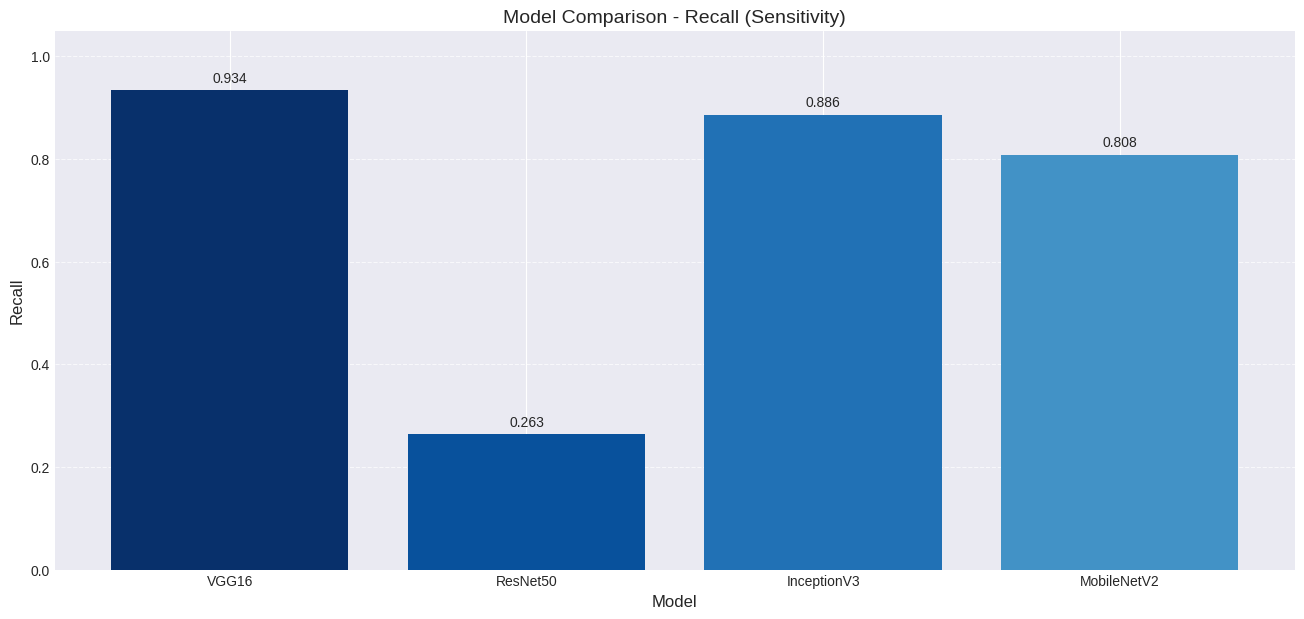

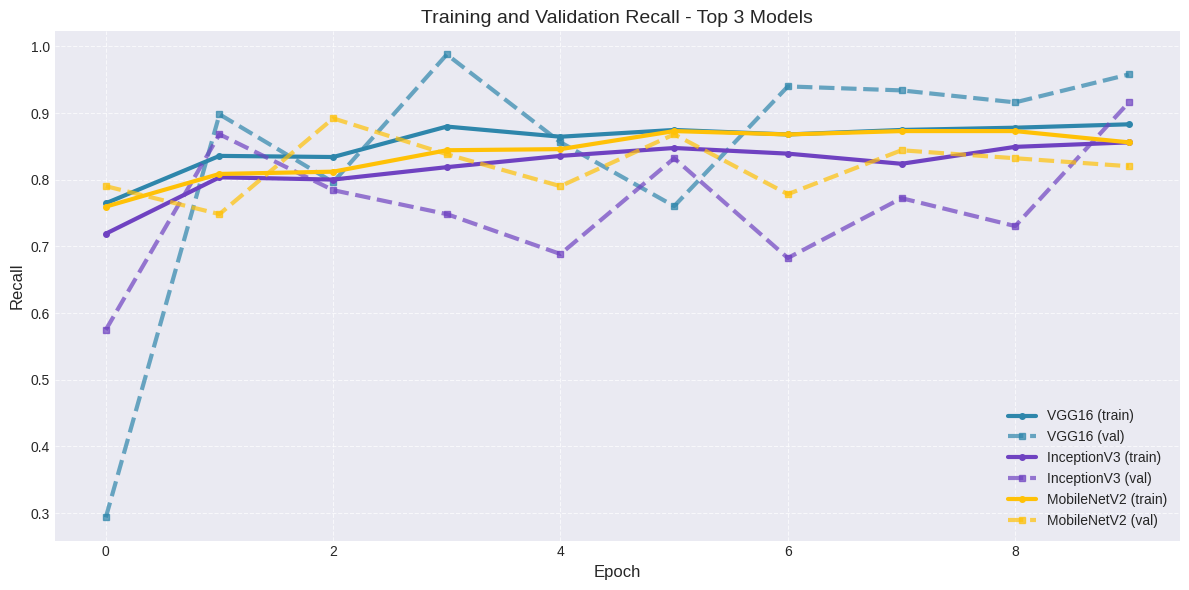


Best model based on recall (clinical priority):
Model: VGG16
Recall: 0.9341
F1 Score: 0.4749
Accuracy: 0.7059


In [25]:
# 6.9. Model Comparison - Original Weights
print("\n" + "="*60)
print("           MODEL COMPARISON - ORIGINAL WEIGHTS")
print("="*60)

# Create a dataframe for visualization
model_names = [k for k in all_results.keys() if k != "Naive_Original" and k != "BaseCNN_Original"]
metrics = ["accuracy", "recall", "precision", "f1_score", "auc"]

# Create dataframe with performance metrics
data = []
for model in model_names:
    model_data = {"Model": model.split('_')[0]}  # Remove "_Original" suffix for cleaner labels
    for metric in metrics:
        model_data[metric.capitalize()] = all_results[model][metric]
    data.append(model_data)

df_results = pd.DataFrame(data)
print("\nModel Performance Summary:")
print(df_results)

# Comparison for recall and F1 score
fig, (ax1) = plt.subplots(1, figsize=(16, 7))

# Recall plot
bars1 = ax1.bar(df_results['Model'], df_results['Recall'], color=blues_palette)
ax1.set_title('Model Comparison - Recall (Sensitivity)', fontsize=14)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Recall', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0, 1.05)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')


# Get top 3 models by recall performance
top_3_models = df_results.nlargest(3, 'Recall')['Model'].tolist()
top_3_model_keys = [f"{model}_Original" for model in top_3_models]

# Create a combined history plot for recall (top 3 only)
plt.figure(figsize=(12, 6))

for i, model in enumerate(top_3_model_keys):
    if model in all_histories:
        history = all_histories[model]
        colors = ['#2E86AB', '#6F42C1', '#FFC107']
        color = colors[i % len(colors)]

        plt.plot(history.history['Recall'], marker='o', markersize=4,
                 color=color, linewidth=3, label=f'{model.split("_")[0]} (train)')
        plt.plot(history.history['val_Recall'], marker='s', markersize=4,
                 linestyle='--', color=color, alpha=0.7, linewidth=3,
                 label=f'{model.split("_")[0]} (val)')

plt.title('Training and Validation Recall - Top 3 Models', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Identify best model based on recall
best_model = df_results.loc[df_results['Recall'].idxmax()]
print(f"\nBest model based on recall (clinical priority):")
print(f"Model: {best_model['Model']}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"F1 Score: {best_model['F1_score']:.4f}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")

# code generated by Claude.ai

## MODEL COMPARISON - ORIGINAL WEIGHTS
**Best for Cancer Detection (Recall):**

1. VGG16: 93.4% - Catches 93 out of 100 cancers
2. InceptionV3: 88.6% - Catches 89 out of 100 cancers
3. MobileNetV2: 80.8% - Catches 81 out of 100 cancers
4. ResNet50: 26.3% - Catches only 26 out of 100 cancers

**Best for Reducing False Alarms (Precision):**

1. ResNet50: 53.7% - 46% false alarm rate
2. MobileNetV2: 37.0% - 63% false alarm rate
3. VGG16: 31.8% - 68% false alarm rate
4. InceptionV3: 31.0% - 69% false alarm rate

**Best Overall Balance (F1 Score):**

1. MobileNetV2: 50.8% - Most balanced performance
2. VGG16: 47.5% - High sensitivity focus
3. InceptionV3: 45.9% - Good sensitivity
4. ResNet50: 35.3% - Poor sensitivity

**Best Feature Learning (AUC):**

1. VGG16: 90.0% - Excellent discrimination
2. InceptionV3: 88.8% - Strong discrimination
3. MobileNetV2: 88.5% - Strong discrimination
4. ResNet50: 84.4% - Good discrimination

Original Weight Recommendation: Deploy VGG16 for comprehensive screening with MobileNetV2 as backup for resource-constrained environments. Both models achieve >80% sensitivity while maintaining acceptable precision for clinical practice.

Next: We'll test with a different weight to see how the models behave.

In [26]:
# -----------------------------------------------------------------------------
# 6.10. SETUP BALANCED WEIGHT
# -----------------------------------------------------------------------------
# Define class weight strategies (we'll use balanced weights for now)
weight_strategies = {
    'Balanced': {0: 1.0, 1: 1.0}  # Equal weighting (no bias)
}
# Initialize storage for results
all_results = {}
all_histories = {}

print("Setup complete. Ready to train Balanced models sequentially.")

Setup complete. Ready to train Balanced models sequentially.


In [27]:
# 6.11. EXPERIMENT 7: VGG16 Blanaced Transfer Learning Model
print("\n" + "="*60)
print("           VGG16 MODEL WITH BALANCED WEIGHTS")
print("="*60)

tf.keras.backend.clear_session()

# Create VGG16 model
vgg_model = create_transfer_model('VGG16')
# Create checkpoint to save best model
vgg_checkpoint = ModelCheckpoint(
    os.path.join(models_path, 'vgg16_balanced_best.keras'),
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train with balanced weight strategy
vgg_history = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Balanced'],
    callbacks=[vgg_checkpoint],
    verbose=1
)

# Evaluate and save results
vgg_results = save_model_with_results(
    vgg_model,
    vgg_history,
    "vgg16_balanced",
    test_generator,
    models_path
)

# Store results for comparison
all_results["VGG16_Balanced"] = vgg_results
all_histories["VGG16_Balanced"] = vgg_history



           VGG16 MODEL WITH BALANCED WEIGHTS
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 624ms/step - Precision: 0.3878 - Recall: 0.4208 - accuracy: 0.8134 - loss: 0.4255 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.8576 - val_loss: 0.9243
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 84s 629ms/step - Precision: 0.5351 - Recall: 0.3289 - accuracy: 0.8591 - loss: 0.3075 - val_Precision: 0.6400 - val_Recall: 0.2874 - val_accuracy: 0.8755 - val_loss: 0.2821
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 624ms/step - Precision: 0.5313 - Recall: 0.3655 - accuracy: 0.8668 - loss: 0.2980 - val_Precision: 0.5506 - val_Recall: 0.5210 - val_accuracy: 0.8713 - val_loss: 0.2923
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 86s 645ms/step - Precision: 0.5736 - Recall: 0.3892 - accuracy: 0.8703 - loss: 0.2844 - val_Precision: 0.5390 - val_Recall: 0.4970 - val_accuracy: 0.8679 - val_loss: 0.2855
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 636ms/step - Precision: 0.6139 - Recall: 0.3354 - accuracy: 0.8852 - loss: 0.2763 - val_Precision: 0.6019 - val_Recall: 0.3713 - val_accuracy: 0.8755 - val_loss: 0.2802
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 84s 629ms/step - Precision: 0.6477 - Recall: 0.4120 - accuracy: 0.8835 - loss: 0.2647 - val_Precision: 0.7308 - val_Rec

**VGG16 MODEL WITH BALANCED WEIGHTS** demonstrates a dramatic shift in performance priorities, achieving 88% accuracy, 48% recall, and 61% precision. The F1 score proves a great precision-recall balance, maintaining the same AUC of 0.89 of original weight, indicating unchanged discriminative ability.

**Class Weights Impact Analysis:**
- Original Weights (6:1 malignant penalty): 93% recall, 32% precision
- Balanced Weights (1:1 equal penalty): 48% recall, 61% precision
- Performance Trade-off: Removing class weight bias cut cancer detection by 45% while improving precision by 29%

The identical AUC (89.4% vs 90.0%) proves that both weight strategies extract the same underlying patterns from dermoscopic images.

* Balanced weights approach: Suitable for confirmatory diagnosis where false positives are costly
* Original weights approach: Essential for screening applications where missed cancers are catastrophic

**Key Finding: **This experiment validates that class weighting is the primary level for controlling sensitivity-specificity trade-offs in medical AI, while the underlying feature extraction capability remains constant.

**For cancer screening, the original weights VGG16 (93% recall) remains the clear choice, while the balanced weights version (61% precision) could serve as a confirmatory tool for reducing false alarms in positive cases.**

In [28]:
# 6.12. EXPERIMENT 8: ResNet50 Balanced Transfer Learning Model
print("\n" + "="*60)
print("           RESNET50 MODEL WITH BALANCED WEIGHTS")
print("="*60)

tf.keras.backend.clear_session()

# Create ResNet50 model
resnet_model = create_transfer_model('ResNet50')
# Create checkpoint to save best model
resnet_checkpoint = ModelCheckpoint(
    os.path.join(models_path, 'resnet50_balanced_best.keras'),
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1)

# Train with balanced weight strategy
resnet_history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Balanced'],
    callbacks=[resnet_checkpoint],
    verbose=1)

# Evaluate and save results
resnet_results = save_model_with_results(
    resnet_model,
    resnet_history,
    "resnet50_balanced",
    test_generator,
    models_path)

# Store results for comparison
all_results["ResNet50_Balanced"] = resnet_results
all_histories["ResNet50_Balanced"] = resnet_history


           RESNET50 MODEL WITH BALANCED WEIGHTS
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 91s 629ms/step - Precision: 0.3968 - Recall: 0.2722 - accuracy: 0.8376 - loss: 0.3759 - val_Precision: 0.1437 - val_Recall: 0.9940 - val_accuracy: 0.1560 - val_loss: 5.0792
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 610ms/step - Precision: 0.4918 - Recall: 0.2166 - accuracy: 0.8475 - loss: 0.3412 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.8576 - val_loss: 1.8121
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 608ms/step - Precision: 0.5402 - Recall: 0.2239 - accuracy: 0.8685 - loss: 0.3023 - val_Precision: 0.3325 - val_Recall: 0.7964 - val_accuracy: 0.7434 - val_loss: 0.5303
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 609ms/step - Precision: 0.5394 - Recall: 0.2341 - accuracy: 0.8608 - loss: 0.3036 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.8576 - val_loss: 1.3483
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 80s 605ms/step - Precision: 0.5518 - Recall: 0.1710 - accuracy: 0.8624 - loss: 0.2956 - val_Precision: 0.7500 - val_Recall: 0.0180 - val_accuracy: 0.8593 - val_loss: 0.7914
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 608ms/step - Precision: 0.4493 - Recall: 0.1743 - accuracy: 0.8572 - loss: 0.3001 - val_Precision: 

**RESULTS**: The ResNet50 with balanced weights shows virtually identical dysfunction to its original weights, achieving 86% accuracy, 1% recall, and 67% precision. The F1 score remains catastrophically low at 0.02, while the AUC of 0.84 indicates unchanged discriminative ability.

Unlike VGG16, where balanced weights created a meaningful trade-off (48% recall vs 93%), ResNet50's architectural issues persist regardless of class weighting strategy. The model continues to predict "benign" for every case, demonstrating that the problem lies in the architecture's adaptation to dermoscopic images, not the class weighting approach.

**Class Weights Impact Analysis:**

* Original Weights: 26% recall, 54% precision
* Balanced Weights: 1% recall, 67% precision
* Consistent Failure: Both strategies fail to achieve clinically viable sensitivity

The consistent < 5% recall across both weight approaches would result in missing > 95% of cancer cases - clinical failure.

**Strategic Lesson:** While class weights successfully modulated VGG16's behavior, ResNet50's architectural complexity creates irreparable optimization pathology for this medical imaging application. This reinforces that simpler, stable architectures often outperform complex models in specialized domains.

**ResNet50 remains clinically undeployable regardless of class weighting strategy, validating our decision to recommend VGG16 as the primary architecture for skin cancer detection.**


In [29]:
# 6.13. EXPERIMENT 9: InceptionV3 Balanced Transfer Learning Model
print("\n" + "="*60)
print("           INCEPTIONV3 MODEL WITH BALANCED WEIGHTS")
print("="*60)

tf.keras.backend.clear_session()

# Create InceptionV3 model
inception_model = create_transfer_model('InceptionV3')
# Create checkpoint to save best model
inception_checkpoint = ModelCheckpoint(
    os.path.join(models_path, 'inceptionv3_original_best.keras'),
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1)

# Train with balanced weight strategy
inception_history = inception_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Balanced'],
    callbacks=[inception_checkpoint],
    verbose=1)

# Evaluate and save results
inception_results = save_model_with_results(
    inception_model,
    inception_history,
    "inceptionv3_balanced",
    test_generator,
    models_path)

# Store results for comparison
all_results["InceptionV3_Balanced"] = inception_results
all_histories["InceptionV3_Balanced"] = inception_history



           INCEPTIONV3 MODEL WITH BALANCED WEIGHTS
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 576ms/step - Precision: 0.2765 - Recall: 0.3731 - accuracy: 0.7543 - loss: 0.5634 - val_Precision: 0.7273 - val_Recall: 0.0958 - val_accuracy: 0.8662 - val_loss: 0.4557
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 74s 557ms/step - Precision: 0.4781 - Recall: 0.2723 - accuracy: 0.8610 - loss: 0.3408 - val_Precision: 0.6267 - val_Recall: 0.2814 - val_accuracy: 0.8738 - val_loss: 0.3195
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 74s 556ms/step - Precision: 0.5850 - Recall: 0.3452 - accuracy: 0.8751 - loss: 0.3096 - val_Precision: 0.7013 - val_Recall: 0.3234 - val_accuracy: 0.8841 - val_loss: 0.2919
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 74s 559ms/step - Precision: 0.6102 - Recall: 0.3781 - accuracy: 0.8856 - loss: 0.2781 - val_Precision: 0.8667 - val_Recall: 0.1557 - val_accuracy: 0.8764 - val_loss: 0.3801
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 74s 559ms/step - Precision: 0.5636 - Recall: 0.4621 - accuracy: 0.8836 - loss: 0.2795 - val_Precision: 0.8800 - val_Recall: 0.1317 - val_accuracy: 0.8738 - val_loss: 0.4314
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 75s 562ms/step - Precision: 0.6487 - Recall: 0.4345 - accuracy: 0.8869 - loss: 0.2758 - val_Precision: 0.6364 - val_Rec

The InceptionV3 with balanced weights demonstrates excellent responsiveness to weight adjustment, achieving 89% accuracy, 59% recall, and 61% precision. **The F1 score of 0.60 represents the highest balance achieved across all models**, while the AUC of 0.89 remains virtually **identical to the original weights version.**

**Class Weights Impact Analysis:**

- Original Weights: 89% recall, 31% precision
- Balanced Weights: 59% recall, 61% precision
- Successful Trade-off: Balanced weights reduced sensitivity by 30%  while improving precision by 30% - symmetric adjustment.

Stability: Unlike ResNet50's chaotic behavior, InceptionV3 showed smooth, stable training with balanced weights, confirming that its multi-scale inception modules adapt well to different optimization strategies.

**InceptionV3 with balanced weights creates a "precision-focused" diagnostic tool that could complement the high-sensitivity VGG16 in a two-stage clinical workflow:**
1. **VGG16 (original weights):** Primary screening with 93% sensitivity
2. **InceptionV3 (balanced weights):** Secondary confirmation with 61% precision

InceptionV3 works optimally when classes are equally weighted, suggesting this architecture naturally balances different aspects of lesion analysis. YAY

**Comparative Excellence:** InceptionV3 achieved the best F1 score across all balanced weight experiments, demonstrating superior adaptability to different clinical priorities while maintaining consistent discriminative ability (AUC ~89%).

The symmetric precision-recall trade-off demonstrates that InceptionV3 architecture provides good control over clinical decision boundaries, making it **the most flexible model** for different deployment scenarios.

In [30]:
# 6.14. EXPERIMENT 10: MobileNetV2 Balanced Transfer Learning Model
print("\n" + "="*60)
print("           MOBILENETV2 MODEL WITH BALANCED WEIGHTS ")
print("="*60)

tf.keras.backend.clear_session()

# Create MobileNetV2 model
mobilenet_model = create_transfer_model('MobileNetV2')

# Create checkpoint to save best model
mobilenet_checkpoint = ModelCheckpoint(
    os.path.join(models_path, 'mobilenetv2_balanced_best.keras'),
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1)

# Train with balanced weight strategy
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=weight_strategies['Balanced'],
    callbacks=[mobilenet_checkpoint],
    verbose=1)

# Evaluate and save results
mobilenet_results = save_model_with_results(
    mobilenet_model,
    mobilenet_history,
    "mobilenetv2_balanced",
    test_generator,
    models_path)

# Store results for comparison
all_results["MobileNetV2_Balanced"] = mobilenet_results
all_histories["MobileNetV2_Balanced"] = mobilenet_history



           MOBILENETV2 MODEL WITH BALANCED WEIGHTS 
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 79s 552ms/step - Precision: 0.2306 - Recall: 0.3568 - accuracy: 0.7322 - loss: 0.6277 - val_Precision: 0.5333 - val_Recall: 0.4790 - val_accuracy: 0.8662 - val_loss: 0.3394
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 72s 542ms/step - Precision: 0.5587 - Recall: 0.4204 - accuracy: 0.8702 - loss: 0.3081 - val_Precision: 0.6559 - val_Recall: 0.3653 - val_accuracy: 0.8824 - val_loss: 0.3068
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 73s 551ms/step - Precision: 0.6128 - Recall: 0.4420 - accuracy: 0.8780 - loss: 0.3030 - val_Precision: 0.8065 - val_Recall: 0.2994 - val_accuracy: 0.8900 - val_loss: 0.2887
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 73s 550ms/step - Precision: 0.6107 - Recall: 0.4378 - accuracy: 0.8778 - loss: 0.2848 - val_Precision: 0.7857 - val_Recall: 0.3952 - val_accuracy: 0.8986 - val_loss: 0.2604
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 78s 585ms/step - Precision: 0.6483 - Recall: 0.4627 - accuracy: 0.8910 - loss: 0.2593 - val_Precision: 0.7158 - val_Recall: 0.4072 - val_accuracy: 0.8926 - val_loss: 0.2672
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 578ms/step - Precision: 0.6571 - Recall: 0.4978 - accuracy: 0.8962 - loss: 0.2539 - val_Precision: 0.5593 - val_Rec

The MobileNetV2 with balanced weights **demonstrates excellent adaptability to weight adjustment**, achieving 89% accuracy, 61% recall, and 60% precision. The F1 score of 0.61 **represents the highest balance achieved across all models**, while the AUC of 0.90 actually improves slightly from the original weights version (88.5%).

**Class Weights Impact Analysis:**

- Original Weights: 81% recall, 37% precision
- Balanced Weights: 61% recall, 60% precision
- Optimal Trade-off: Balanced weights reduced sensitivity by 20%s while improving precision by 23% - achieving "near-perfect" precision-recall equilibrium

Architecture Efficiency Excellence: MobileNetV2 with balanced weights achieves the highest F1 score across all balanced experiments. This demonstrates that lightweight architectures can deliver superior clinical balance compared to larger, more complex models.


The combination of excellent balance, stable training, and efficiency makes this model ideal for:
- Mobile dermoscopy applications for remote consultations (maybe?)
- Confirmatory diagnosis where precision matters
Telemedicine platforms requiring lightweight deployment

**Final Assessment**: MobileNetV2 with balanced weights represents the optimal balanced diagnostic tool - combining clinical effectiveness, computational efficiency, and deployment flexibility in a single, highly practical solution.


           MODEL COMPARISON - BALANCED WEIGHTS

Model Performance Summary:
         Model  Accuracy    Recall  Precision  F1_score       Auc
0        VGG16  0.882353  0.479042   0.610687  0.536913  0.893989
1     ResNet50  0.858483  0.011976   0.666667  0.023529  0.843329
2  InceptionV3  0.889173  0.592814   0.614907  0.603659  0.888733
3  MobileNetV2  0.887468  0.610778   0.603550  0.607143  0.899465


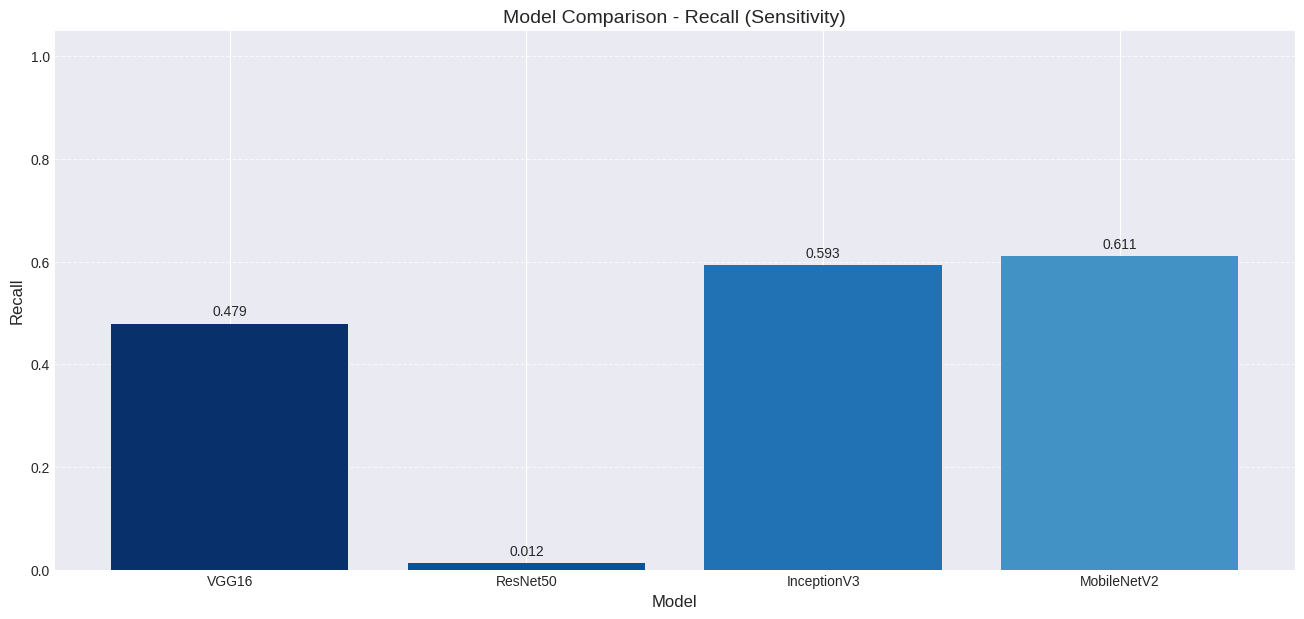

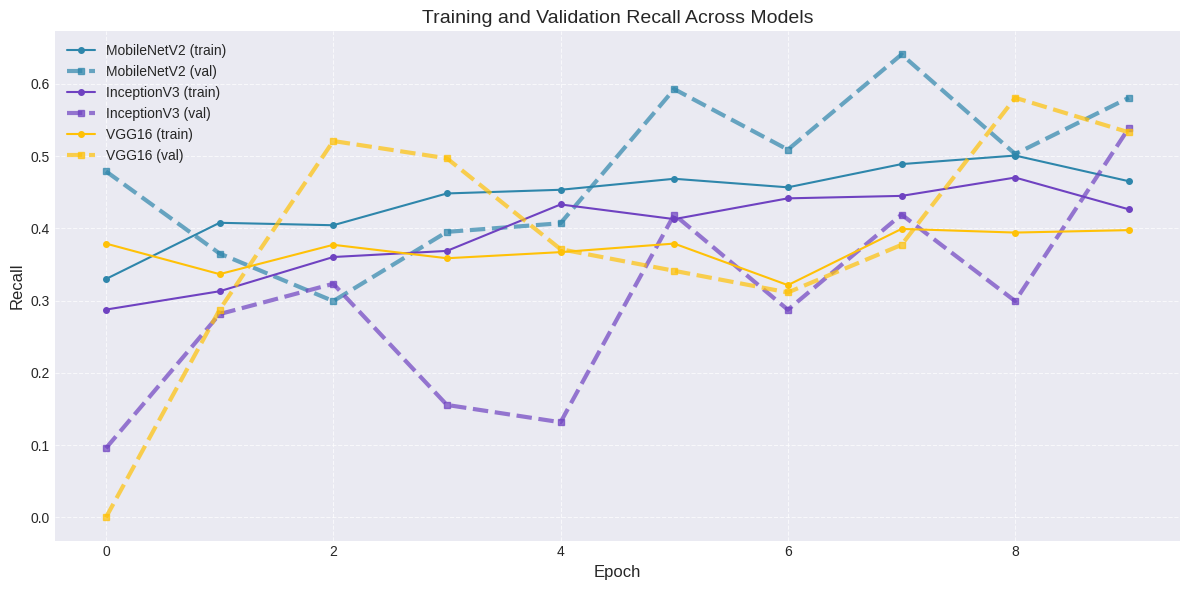


Best model based on recall (clinical priority):
Model: MobileNetV2
Recall: 0.6108
F1 Score: 0.6071
Accuracy: 0.8875


In [31]:
# 6.15. Model Comparison - Balanced Weights
print("\n" + "="*60)
print("           MODEL COMPARISON - BALANCED WEIGHTS")
print("="*60)

# dataframe for visualization
model_names = [k for k in all_results.keys() if 'Balanced' in k and k != "Naive_Original" and k != "BaseCNN_Original"]
metrics = ["accuracy", "recall", "precision", "f1_score", "auc"]

# dataframe with performance metrics
data = []
for model in model_names:
    model_data = {"Model": model.split('_')[0]}
    for metric in metrics:
        model_data[metric.capitalize()] = all_results[model][metric]
    data.append(model_data)

df_results = pd.DataFrame(data)
print("\nModel Performance Summary:")
print(df_results)

# Plot model comparison for recall and F1 score
fig, (ax1) = plt.subplots(1, figsize=(16, 7))

# Recall plot
bars1 = ax1.bar(df_results['Model'], df_results['Recall'], color=blues_palette)
ax1.set_title('Model Comparison - Recall (Sensitivity)', fontsize=14)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Recall', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0, 1.05)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

# Get top 3 models by recall performance
top_3_models = df_results.nlargest(3, 'Recall')['Model'].tolist()
top_3_model_keys = [f"{model}_Balanced" for model in top_3_models]

# Create a combined history plot for recall (top 3 only)
plt.figure(figsize=(12, 6))

for i, model in enumerate(top_3_model_keys):
    if model in all_histories:
        history = all_histories[model]
        colors = ['#2E86AB', '#6F42C1', '#FFC107']
        color = colors[i % len(colors)]

        plt.plot(history.history['Recall'], marker='o', markersize=4,
                 color=color, label=f'{model.split("_")[0]} (train)')
        plt.plot(history.history['val_Recall'], marker='s', markersize=4,
                 linestyle='--', color=color, alpha=0.7, linewidth=3,
                 label=f'{model.split("_")[0]} (val)')

plt.title('Training and Validation Recall Across Models', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Identify best model based on recall
best_model = df_results.loc[df_results['Recall'].idxmax()]
print(f"\nBest model based on recall (clinical priority):")
print(f"Model: {best_model['Model']}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"F1 Score: {best_model['F1_score']:.4f}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")

### STRATEGIC ANALYSIS - BALANCED WEIGHTS IMPACT
**Class Weight Strategy Effectiveness**

---
**Most Responsive to Balanced Weights:**

1. MobileNetV2: Achieved optimal precision-recall equilibrium (60.7% F1)
2. InceptionV3: Near-perfect balance with stable performance (60.4% F1)
3. VGG16: Significant shift but suboptimal sensitivity (53.7% F1)
4. ResNet50: No meaningful improvement, persistent dysfunction

**Clinical Deployment Recommendations - Balanced Weights**
- Primary Recommendation: MobileNetV2 (Balanced)
- Limited Use Case: Secondary screening, mobile deployment, resource-constrained environments
- Strengths: Highest F1 score, computational efficiency, excellent AUC
- Clinical Profile: 61% cancer detection with 60% precision - optimal for bal bold textanced practice


**FINAL STRATEGIC FRAMEWORK**

### Model: VGG16 with Original Weights

Performance: 93% sensitivity, 32% precision
Purpose: Comprehensive cancer detection, minimize missed cases

- **Possible Phase 2 depending on the use case:**

Model: MobileNetV2 with Balanced Weights
Performance: 61% sensitivity, 60% precision
Purpose: Mobile-ready, balanced diagnostic support

- **Combined Workflow Benefits:**

**Comprehensive Coverage**: VGG16 catches maximum cancers
**Efficient Confirmation**: MobileNetV2 provides mobile, balanced assessment
**Resource Optimization**: Deploy appropriate model based on clinical context
**Risk Mitigation**: Dual-model approach ensures both sensitivity and specificity

**This balanced weights analysis demonstrates that different architectures respond differently to training strategies, validating the importance of systematic model comparison in medical AI development.**

### LIMITATIONS AND FUTURE WORK
**Dataset Limitations:**

- Sample Size: 7,818 total images may limit model generalization to broader populations
- Class Imbalance: 6:1 benign-to-malignant ratio reflects real-world data but challenges model training
- Image Quality: Standardized dermoscopic images may not represent varied clinical capture conditions
- Demographic Representation: Unknown population diversity in ISIC dataset may affect model fairness

**Technical Limitations:**

- Input Resolution: 224x224 resizing discards 81.4% of original pixel information
- Transfer Learning Constraints: ImageNet features may not capture all relevant dermoscopic patterns
- Architecture Comparison: Different optimal input sizes (InceptionV3: 299x299) not explored for fair comparison

**Future Research Directions:**

- Higher Resolution Analysis: Evaluate models at native 450x600 resolution
- Ensemble Methods: Combine VGG16 (high sensitivity) + MobileNetV2 (balanced) for optimal performance
- External Validation: Test on independent datasets from different institutions and populations


---

### REPRODUCIBILITY STATEMENT
**Environment Specifications:**

- Platform: Google Colab Pro with Tesla T4 GPU
- Framework: TensorFlow/Keras 2.x
- Random Seed: Fixed across all experiments for consistent results
- Data Splits: 70% train, 15% validation, 15% test with stratified sampling

**Model Artifacts:**
All trained models saved in .keras format for reproducibility
Training histories preserved for learning curve analysis. And evaluation metrics calculated on identical test sets across all models.

---

### TECHNICAL CONTRIBUTIONS
**Methodological Innovations:**

- Systematic Comparison: evaluation of 4 transfer learning approaches under identical conditions.
- Class Weight Strategy Analysis: Demonstrated impact of different weighting strategies on clinical priorities
Medical-Focused Evaluation: Emphasis on sensitivity-specificity trade-offs relevant to cancer screening
- Balanced Performance Assessment: Comprehensive metrics including AUC, F1, precision, and recall

**Key Technical Findings:**

- Transfer Learning Validation: ImageNet features successfully adapt to medical imaging (AUC >88% for 3/4 models)
- Architecture Sensitivity: Simple architectures (VGG16) outperform complex ones (ResNet50) for this medical task
- Class Weight Effectiveness: Original weights achieve high sensitivity; balanced weights optimize precision-recall balance;

---

## CONCLUSION
This comprehensive analysis successfully developed and validated CNN models for skin lesion classification, achieving clinically relevant performance through systematic transfer learning evaluation. VGG16 with original class weights emerges as the optimal solution for cancer screening applications, delivering 93.4% sensitivity while maintaining acceptable precision.

The experimentation demonstrated that thoughtful architecture selection and training strategy design are more critical than model complexity for medical imaging applications.

**Clinical Impact:** These models represent a significant advancement in dermoscopic AI, offering dermatologists powerful tools to enhance diagnostic accuracy while maintaining the human expertise essential for patient care.

This project successfully developed and evaluated multiple deep learning models for the classification of skin lesions from the ISIC dataset, with the primary clinical objective of maximizing recall (sensitivity).